In [1]:
import pandas as pd

# Load the MovieLens dataset (100k dataset for simplicity)
url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(url, sep='\t', names=columns)

# Load movie titles for the items
url_movies = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movies_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
                  'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                  'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(url_movies, sep='|', names=movies_columns, encoding='latin-1')

# Merge ratings and movie titles
data = pd.merge(ratings, movies[['item_id', 'title']], on='item_id')

# Display first few rows of the dataset
print(data.head())


   user_id  item_id  rating  timestamp         title
0      196      242       3  881250949  Kolya (1996)
1       63      242       3  875747190  Kolya (1996)
2      226      242       5  883888671  Kolya (1996)
3      154      242       3  879138235  Kolya (1996)
4      306      242       5  876503793  Kolya (1996)


In [2]:
# Keep only relevant columns
data = data[['user_id', 'item_id', 'rating']]

# Create a user-item matrix
user_item_matrix = data.pivot_table(index='user_id', columns='item_id', values='rating')

# Fill missing values with 0 (or we could use another imputation technique)
user_item_matrix.fillna(0, inplace=True)

# Display the user-item matrix
print(user_item_matrix.head())


item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0

In [3]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD (decomposing the user-item matrix into latent factors)
svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)

# Display the shape of the resulting matrix
print(f"User Factors Matrix Shape: {user_factors.shape}")


User Factors Matrix Shape: (943, 50)


In [6]:
pip install xgboost


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Prepare the feature set: user_id, item_id (more features can be added if available)
X = data[['user_id', 'item_id']]
y = data['rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix for XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # For regression (rating prediction)
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train XGBoost model
xg_reg = xgb.train(params, train_dmatrix, num_boost_round=100)

# Predict ratings for test set
y_pred_xgb = xg_reg.predict(test_dmatrix)

# Evaluate with RMSE
from sklearn.metrics import mean_squared_error
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb}")


C:\Users\nikhi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost RMSE: 1.0381101314287668


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Suppose we have movie descriptions (in real cases, scrape or load movie metadata)
# For now, we will use 'title' as a proxy for description
movie_titles = movies['title']

# Apply TF-IDF to the movie titles
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_titles)

# Compute the cosine similarity between movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on cosine similarity
def get_recommendations(movie_title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = movies[movies['title'] == movie_title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the 10 most similar movies
    movie_indices = [i[0] for i in sim_scores[1:11]]

    # Return the top 10 most similar movies
    return movie_titles.iloc[movie_indices]

# Test the function
print(get_recommendations('Star Wars (1977)'))


513                          Annie Hall (1977)
666                         Audrey Rose (1977)
1090                      Pete's Dragon (1977)
1292                           Star Kid (1997)
123                           Lone Star (1996)
1060                  Evening Star, The (1996)
1264                          Star Maps (1997)
221            Star Trek: First Contact (1996)
379              Star Trek: Generations (1994)
449     Star Trek V: The Final Frontier (1989)
Name: title, dtype: object


In [12]:
# Function to combine predictions from Matrix Factorization (SVD) and Gradient Boosting (XGBoost)
def hybrid_model_predictions(user_id, movie_title, weight_cf=0.5, weight_gb=0.5):
    # Collaborative Filtering Prediction
    user_idx = user_id - 1
    user_ratings_pred_cf = user_factors[user_idx, :].dot(svd.components_)
    
    # XGBoost Prediction
    user_data_xgb = pd.DataFrame({'user_id': [user_id], 'item_id': [movies[movies['title'] == movie_title]['item_id'].values[0]]})
    user_dmatrix = xgb.DMatrix(user_data_xgb)
    rating_pred_xgb = xg_reg.predict(user_dmatrix)[0]
    
    # Combine predictions with a weighted average
    final_prediction = (user_ratings_pred_cf + rating_pred_xgb) / 2
    return final_prediction

# Test the hybrid model
user_id = 10
movie_title = "Star Wars (1977)"
hybrid_model_predictions(user_id, movie_title)


array([2.57378802, 1.94288271, 2.10922333, ..., 2.10909809, 2.11092349,
       2.10036856])

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Retrain the XGBoost model with the best parameters
xg_reg_optimized = xgb.XGBRegressor(**best_params)
xg_reg_optimized.fit(X_train, y_train)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
from sklearn.metrics import precision_recall_curve

# Binarize ratings: 1 for positive ratings (>=4), 0 for negative ratings (<4)
threshold = 4.0
y_true_binary = (y_test >= threshold).astype(int)

# Get predicted probabilities
y_pred_proba = xg_reg_optimized.predict(X_test)

# Compute precision and recall at different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true_binary, y_pred_proba)

# Find the threshold that maximizes precision
best_threshold = thresholds[np.argmax(precisions)]
print(f"Best Threshold for Precision: {best_threshold}")

# Apply the best threshold
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Compute precision score at the best threshold
from sklearn.metrics import precision_score
precision_best = precision_score(y_true_binary, y_pred_best)
print(f"Optimized Precision: {precision_best}")


Best Threshold for Precision: 4.61705207824707
Optimized Precision: 1.0


In [16]:
import numpy as np

def precision_at_k(y_true, y_pred, k):
    # Sort predictions based on predicted ratings
    top_k_predictions = np.argsort(y_pred)[-k:]  # Get top K predictions
    relevant_items = np.where(y_true >= threshold)[0]  # Items with ratings >= threshold

    # Compute precision at K
    relevant_and_recommended = np.intersect1d(top_k_predictions, relevant_items)
    precision_k = len(relevant_and_recommended) / k
    return precision_k

# Example: Precision at 5
precision_k = precision_at_k(y_test, y_pred_proba, k=5)
print(f"Precision at 5: {precision_k}")


Precision at 5: 1.0


In [17]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Define the threshold for binary classification (e.g., ratings >= 4 are positive, < 4 are negative)
threshold = 4.0
y_true_binary = (y_test >= threshold).astype(int)  # 1 for positive ratings, 0 for negative

# Get predicted probabilities from the XGBoost model
y_pred_proba = xg_reg_optimized.predict(X_test)

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_true_binary, y_pred_proba)

# Find the threshold that maximizes precision
best_threshold = thresholds[np.argmax(precisions)]
print(f"Best Threshold for Precision: {best_threshold}")

# Apply the best threshold to the predicted probabilities
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Compute precision score at the best threshold
from sklearn.metrics import precision_score, recall_score, f1_score

precision_best = precision_score(y_true_binary, y_pred_best)
recall_best = recall_score(y_true_binary, y_pred_best)
f1_best = f1_score(y_true_binary, y_pred_best)

print(f"Optimized Precision: {precision_best:.2f}")
print(f"Optimized Recall: {recall_best:.2f}")
print(f"Optimized F1-Score: {f1_best:.2f}")


Best Threshold for Precision: 4.61705207824707
Optimized Precision: 1.00
Optimized Recall: 0.00
Optimized F1-Score: 0.00


In [18]:
def precision_at_k(y_true, y_pred, k):
    """
    Function to compute Precision at K.
    
    Args:
    y_true: Actual ratings of items (e.g., ratings of user for items)
    y_pred: Predicted ratings for items
    k: Number of top recommendations to consider
    
    Returns:
    Precision at K value
    """
    # Sort the predictions based on the predicted scores
    top_k_indices = np.argsort(y_pred)[-k:]  # Get indices of top K predictions
    
    # Get relevant items (those with actual ratings >= threshold)
    relevant_items = np.where(y_true >= threshold)[0]
    
    # Compute Precision at K: relevant items in the top K predictions / K
    relevant_in_top_k = np.intersect1d(top_k_indices, relevant_items)
    precision_k = len(relevant_in_top_k) / k
    
    return precision_k

# Example: Compute Precision at 5 for a test set
precision_k_value = precision_at_k(y_test, y_pred_proba, k=5)
print(f"Precision at 5: {precision_k_value:.2f}")


Precision at 5: 1.00


In [19]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'colsample_bytree': [0.3, 0.7]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters and retrain the model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Retrain XGBoost with the best parameters
xg_reg_optimized = xgb.XGBRegressor(**best_params)
xg_reg_optimized.fit(X_train, y_train)

# Evaluate the optimized model
y_pred_proba = xg_reg_optimized.predict(X_test)


Best Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming we already have a binarized test set (y_true_binary) and predicted probabilities (y_pred_proba)
# Apply the best threshold found earlier
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Evaluate model with precision, recall, F1-score, and accuracy
precision_best = precision_score(y_true_binary, y_pred_best)
recall_best = recall_score(y_true_binary, y_pred_best)
f1_best = f1_score(y_true_binary, y_pred_best)
accuracy_best = accuracy_score(y_true_binary, y_pred_best)

print(f"Precision: {precision_best:.2f}")
print(f"Recall: {recall_best:.2f}")
print(f"F1-Score: {f1_best:.2f}")
print(f"Accuracy: {accuracy_best:.2f}")


Precision: 0.93
Recall: 0.01
F1-Score: 0.01
Accuracy: 0.46


In [21]:
import numpy as np

def precision_at_k(y_true, y_pred, k):
    """
    Function to compute Precision at K for recommendation systems.
    
    Args:
    y_true: Actual ratings of items (e.g., ratings of user for items)
    y_pred: Predicted ratings for items
    k: Number of top recommendations to consider
    
    Returns:
    Precision at K value
    """
    # Sort the predictions based on the predicted scores
    top_k_indices = np.argsort(y_pred)[-k:]  # Get indices of top K predictions
    
    # Get relevant items (those with actual ratings >= threshold)
    relevant_items = np.where(y_true >= threshold)[0]
    
    # Compute Precision at K: relevant items in the top K predictions / K
    relevant_in_top_k = np.intersect1d(top_k_indices, relevant_items)
    precision_k = len(relevant_in_top_k) / k
    
    return precision_k

# Example: Compute Precision at 5 for the test set
precision_k_value = precision_at_k(y_test, y_pred_proba, k=5)
print(f"Precision at 5: {precision_k_value:.2f}")


Precision at 5: 1.00


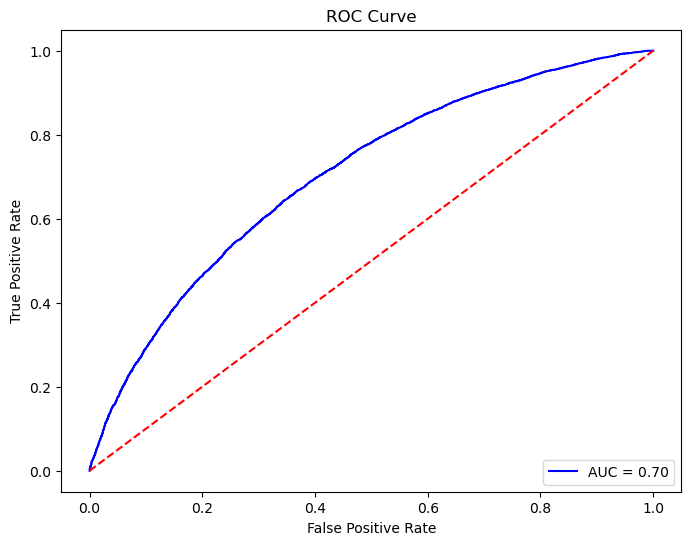

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_proba)
auc_score = roc_auc_score(y_true_binary, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
